Training and predicting with `DeepForestDetector`
--

Train:
--

Here, we use `CustomDataModule` which inherits from `lightning.pytorch.LightningDataModule`

In [1]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader
from tree_detection_framework.preprocessing.derived_geodatasets import CustomDataModule
from tree_detection_framework.detection.detector import DeepForestDetector
from tree_detection_framework.detection.models import DeepForestModule

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Initialize a GeoDataModule instance
datamodule = CustomDataModule(
    train_raster_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    train_vector_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/crowns",
    val_raster_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    val_vector_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/crowns",
    output_res=0.2,
    vector_label_name="treeID",
    batch_size=2,
    size=512,
    stride=400,
)

# Setup the parameters dictionary
param_dict = {
    "backbone": "retinanet",
    "enable_checkpointing": True,
    "train": {"epochs": 3, "lr": 0.001},
    "num_classes": 1,
}

df_module = DeepForestModule(param_dict)
lightning_detector = DeepForestDetector(df_module)
lightning_detector.train(datamodule)

Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.


/ofo-share/repos-amritha/tree-detection-framework/tree_detection_framework/detection/models.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(t

Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RetinaNet | 32.1 M | train
--------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
202       Modules in train mode
0         Modules in eval mode
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a low

Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s] 

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.8992, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0:  20%|██        | 1/5 [00:03<00:13,  0.31it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(1.0026, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0:  40%|████      | 2/5 [00:04<00:06,  0.46it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.9410, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0:  60%|██████    | 3/5 [00:04<00:03,  0.61it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.9218, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0:  80%|████████  | 4/5 [00:05<00:01,  0.67it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(1.0355, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s, v_num=0]        

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='box_recall')` could not find the monitored key in the returned metrics: ['epoch', 'step']. HINT: Did you call `log('box_recall', value)` in the `LightningModule`?
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.9189, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1:  20%|██        | 1/5 [00:00<00:02,  1.59it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.9081, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1:  40%|████      | 2/5 [00:01<00:01,  1.66it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.8894, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1:  60%|██████    | 3/5 [00:01<00:01,  1.67it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.8509, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 1:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(1.0239, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s, v_num=0]        

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.7969, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2:  20%|██        | 1/5 [00:00<00:02,  1.48it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.8654, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2:  40%|████      | 2/5 [00:01<00:01,  1.55it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.8516, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


loss:  tensor(0.8378, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s, v_num=0]

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s, v_num=0]


Predict:
--

In [3]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    chip_size=512,
    chip_stride=400,
    output_resolution=0.2,
    batch_size=3,
)

2024-11-05 18:14:08,587 - INFO - Units = Units.PIXELS
2024-11-05 18:14:08,588 - INFO - Stride = 400


In [ ]:
# This model uses pretrained weights from DeepForest
outputs = lightning_detector.predict(dataloader)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alph

In [5]:
outputs

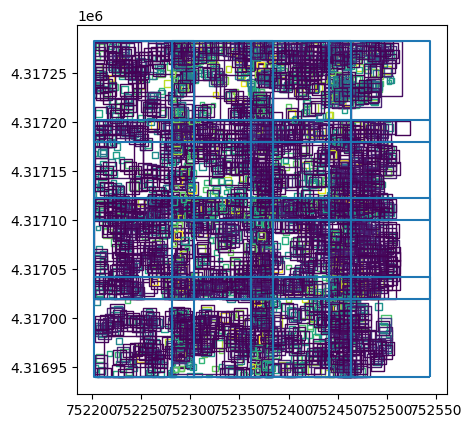

<Axes: >

In [6]:
outputs.plot(visualization_column="scores")

2024-11-05 18:15:29,186 - INFO - Bound have overlap, running across-region NMS


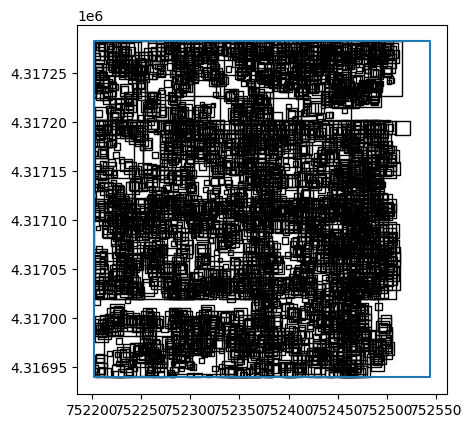

<Axes: >

In [7]:
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS

NMS_outputs = multi_region_NMS(outputs, confidence_column="scores")
NMS_outputs.plot()